In [1]:
# import the required libraries
import numpy as np
import pandas as pd
from time import time
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut
from sklearn.metrics import r2_score, mean_squared_error

C:\Users\HP\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set(font_scale=1.5)

In [4]:
# read the final csv data 
data = pd.read_csv("data/features.csv")
data.shape

(196, 9)

In [5]:
data.describe()

,surface,n_bhk,sa1,pool,sa9,sa7,sa2,sa5,price
count,1.960000e+02,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000
mean,7.533656e-17,2.385204,0.061224,0.632653,0.040816,0.081633,0.051020,0.056122,8.698673
std,1.002561e+00,0.847824,0.240356,0.483317,0.198371,0.274505,0.220603,0.230747,5.807492
min,-2.080191e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.319000
25%,-5.953332e-01,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.100000
50%,-2.634395e-01,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,7.000000
75%,3.943500e-01,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,9.746750
max,4.141817e+00,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,46.000000


In [6]:
# sa1: baner, sa9: nibm, sa7: kharadi, sa2: bavdhan, sa5: handewadi

## Data prepration

In [7]:
data = data.sort_values("surface").reset_index(drop=True)

In [8]:
# Selecting the feature matrix and target vector
X = data.iloc[:, :-1]
y = data["price"]


In [9]:
# Random sate for data splitting
rs = 118
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.3, random_state=rs) 

In [10]:
# function for performing grid search
def gridSearchReport( estimator, X, y, pg, cv=LeaveOneOut(), rs=118 ):
    """
    Performs the grid search and cross validation for the given regressor.
    Params:
        estimator:  the regressor
        X: Pandas dataframe, feature data
        y: Pandas series, target
        pg: dict, parameters' grid
        cv: int, cross-validation generator or an iterable, cross validation folds
        rs: int, training-test split random state
    """    

    t0 = time()
    
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.3, random_state=rs) # train tets split
    
    est_cv = GridSearchCV(
        estimator, 
        param_grid=pg, 
        scoring="neg_mean_squared_error", 
        n_jobs=-1, 
        cv=cv
       )
    
    est_cv.fit(X_train, y_train)
    
    print("Best parameters:", est_cv.best_params_) # best parameters
    print("Best CV score:", abs(est_cv.best_score_)) # cross validation score
    y_train_pred, y_test_pred = est_cv.predict(X_train), est_cv.predict(X_test) # predictions on train and test data
    print("MSE, R2 train:", mean_squared_error(y_train, y_train_pred),  # evaluation metrics
          ", ", r2_score(y_train, y_train_pred) )
    print("MSE, R2 test:", mean_squared_error(y_test, y_test_pred),
          ", ", r2_score(y_test, y_test_pred) )
    
    t = round(time()-t0, 2)
    print("Elapsed time:", t, "s ,", round(t/60, 2), "min")
    
    return est_cv


    

In [11]:
# function to plot the residuals
def plotResidue(estimator, X, y, rs=118):
    """
    Plots the fit residuals (price - predicted_price) vs. "surface" variable.
    Params:
        estimator: GridSearchCV, the regressor
        X: Pandas dataframe, feature data
        y: Pandas series, target
        rs: int, random state
    """    
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.3, random_state=rs) # train tets split

    residue_train = y_train-estimator.predict(X_train) # make predictions
    residue_test = y_test-estimator.predict(X_test)                                                     
                                                          
    fig, axe = plt.subplots(1, 2, figsize=(18,10)) 
    axe[0].scatter( X_train["surface"], residue_train, label="train" )
    axe[0].scatter( X_test["surface"], residue_test, label="test" )
    axe[0].plot( [-2.3, 4.5], [0,0], "black" )
    axe[0].set_xlabel("Scaled surface")
    axe[0].set_ylabel("Fit residulas")
    axe[0].legend()
    
    axe[1].hist(residue_test, bins=25)
    axe[1].set_xlabel("Fit residual for test set")
    axe[1].set_ylabel("Count")


    plt.show()

    print("mean residuals:", round(np.mean(residue_test), 2),
          "\nstd:", round(np.std(residue_test), 2))
    

## Ordinary Linear Regression

In [12]:
# define a simple linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [13]:
# check for the r2 score on train and tets data
r2_score(y_train, lr.predict(X_train)),\
r2_score(y_test, lr.predict(X_test))

(0.7799739568303908, 0.7418384969671954)

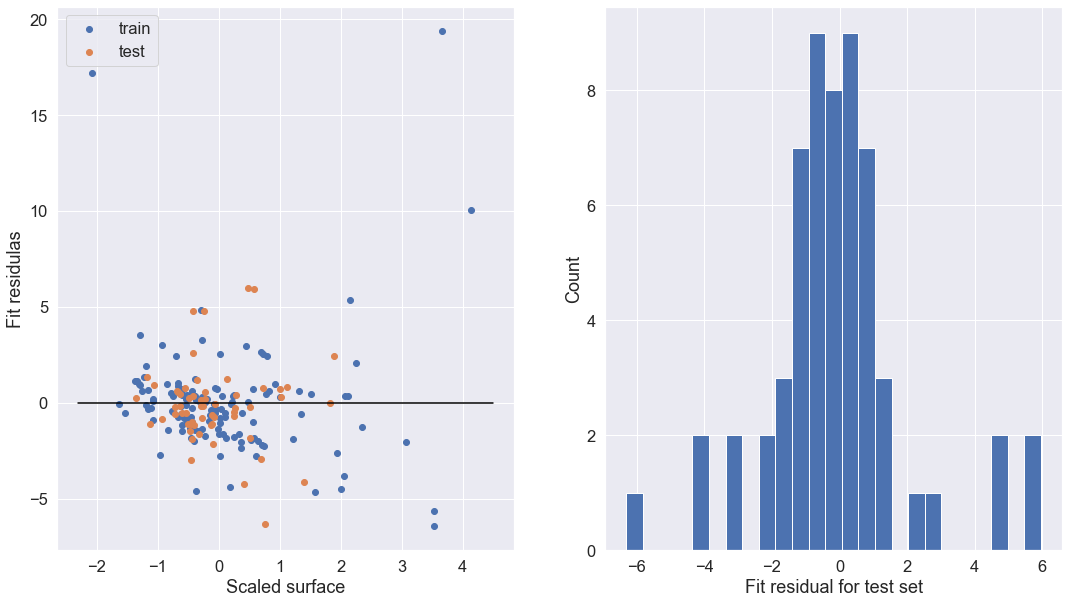

mean residuals: -0.1 
std: 2.1


In [14]:
# plot the residuals
plotResidue(lr, X, y, rs=rs)

## Ridge Regression

In [15]:
# define the parameters for ridge regression model and check for the grid search 
alphas = np.logspace(-3,3,100)
pg = {"alpha":alphas}
ridge = Ridge()
ridg_cv = gridSearchReport( ridge, X, y, pg, rs=rs )

Best parameters: {'alpha': 10.0}
Best CV score: 11.800965273439624
MSE, R2 train: 9.43130688285795 ,  0.7665017863457696
MSE, R2 test: 4.541416900617872 ,  0.7347753550464851
Elapsed time: 61.76 s , 1.03 min


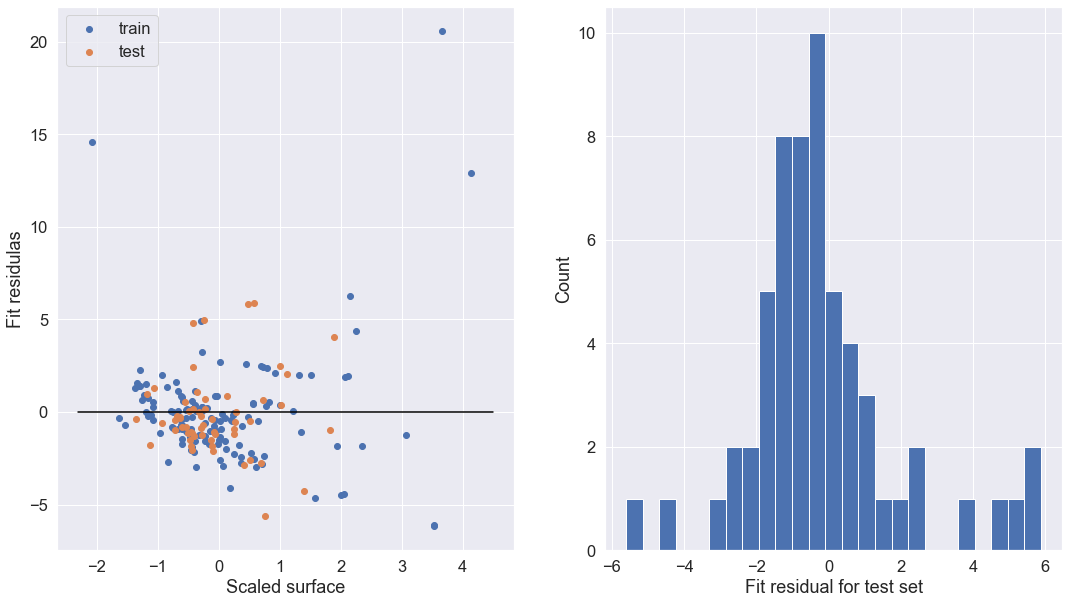

mean residuals: -0.19 
std: 2.12


In [16]:
# plot the residuals
plotResidue(ridg_cv, X, y, rs)

## Lasso Regression

In [17]:
# define the parameters and plot the lasso regression model
lasso = Lasso()
pg = {"alpha":alphas}
lasso_cv = gridSearchReport( lasso, X, y, pg, rs=rs )

Best parameters: {'alpha': 0.3511191734215131}
Best CV score: 11.639635858092893
MSE, R2 train: 10.336902819264557 ,  0.7440812420808165
MSE, R2 test: 5.367273968426112 ,  0.6865442297423997
Elapsed time: 55.02 s , 0.92 min


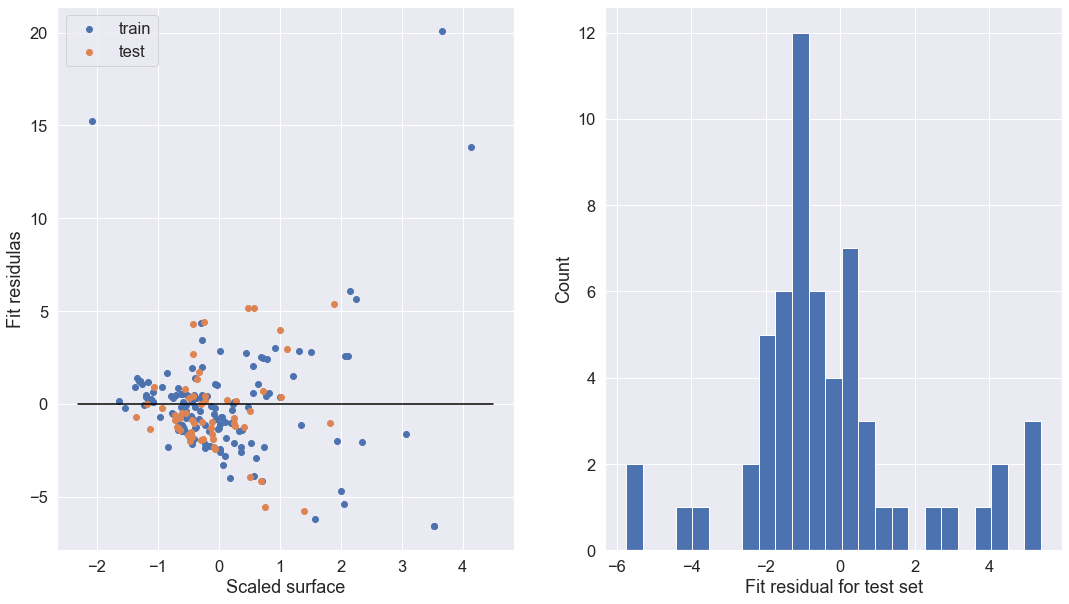

mean residuals: -0.31 
std: 2.3


In [18]:
# plot the residuals 
plotResidue(lasso_cv, X, y, rs=rs)

## Lasso and Ridge Combination

In [19]:
# define an elasticnet model 
l1_ratio = np.random.rand(20)
elastic = ElasticNet()
pg = {"alpha":np.linspace(0.1,1,5), "l1_ratio":l1_ratio}
elastic_cv = gridSearchReport( elastic, X, y, pg, rs=rs )

Best parameters: {'alpha': 0.325, 'l1_ratio': 0.9829231206908797}
Best CV score: 11.629448512528434
MSE, R2 train: 10.333673087427732 ,  0.744161203068604
MSE, R2 test: 5.365485303011588 ,  0.6866486901255553
Elapsed time: 56.84 s , 0.95 min


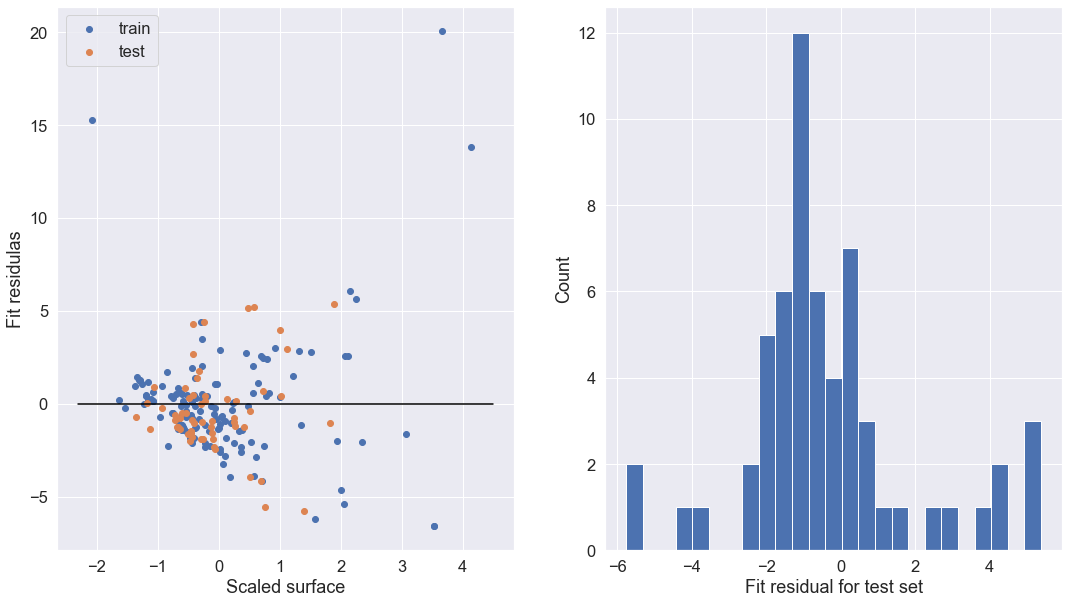

mean residuals: -0.31 
std: 2.29


In [20]:
# plot the residuals
plotResidue(elastic_cv, X, y, rs=rs)

## Random Forest Regressor

In [21]:
# define a random forest regression model 
rfr = RandomForestRegressor( random_state=10 )
pg = {"n_estimators":[10, 20, 30, 50],
         "criterion":["squared_error", "absolute_error", "poisson"],
         "max_depth":[2,3,4],
         "min_samples_split":range(2, 10),
         "min_samples_leaf":[2,3],
         "max_features":range(4, X_train.shape[1]+1) 
        }
rfr_cv = gridSearchReport( rfr, X, y, pg, cv=5, rs=rs )

Best parameters: {'criterion': 'poisson', 'max_depth': 4, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}
Best CV score: 9.534618847932967
MSE, R2 train: 4.8584989409685075 ,  0.8797143558313154
MSE, R2 test: 5.647659109141971 ,  0.6701693733872196
Elapsed time: 652.41 s , 10.87 min


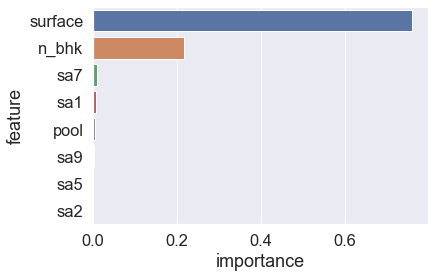

In [22]:
# find the best features 
rfr = rfr_cv.best_estimator_
df_imp = pd.DataFrame(zip(rfr.feature_names_in_, rfr.feature_importances_))
df_imp.columns = ["feature", "importance"]
df_imp = df_imp.sort_values("importance", ascending=False).reset_index(drop=True)

sns.barplot( data=df_imp, x="importance", y="feature"  )
plt.show()

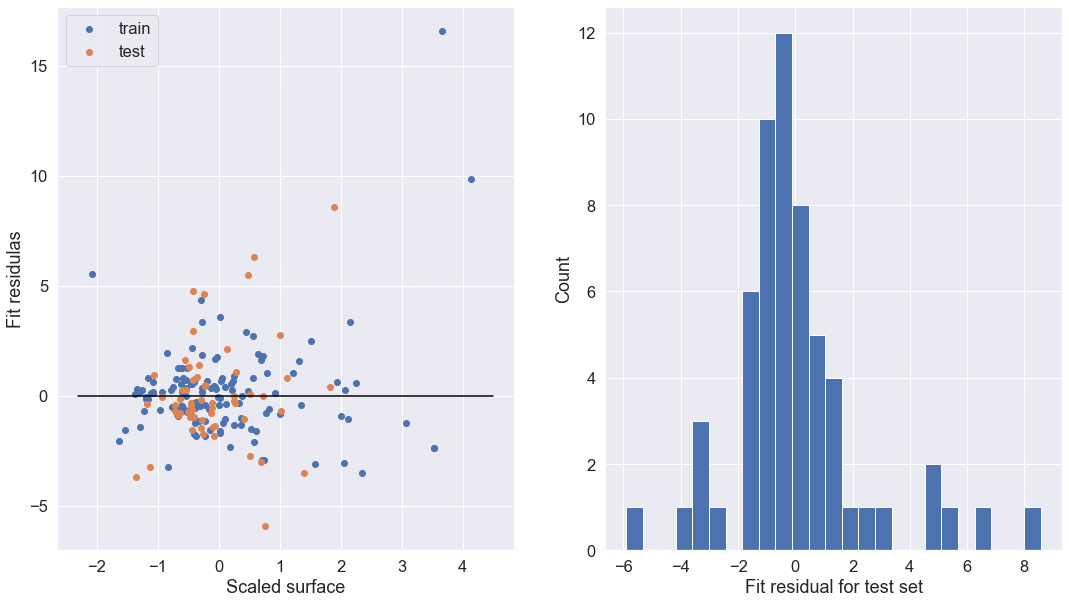

mean residuals: 0.05 
std: 2.38


In [23]:
# plot the residuals
plotResidue(rfr_cv, X, y, rs=rs)

## XGboost (extreme gradient boosting)

In [24]:
# define the parameters for XGBoost model
from scipy.stats import uniform
param_grid = {'max_depth':range(2,7),
      'gamma':uniform(loc=0.0, scale=3), # minimum of the loss function rduction to split a node
      'min_child_weight':range(3,6), # similar to min_samples_leaf
      'colsample_bytree':uniform(loc=0.1, scale=0.9), # similar to the max_features
      'subsample':uniform(loc=0.5, scale=0.5), # similar to bootstraping in RF
      'learning_rate':uniform(loc=0.01, scale=0.99)} # contriburion rate of each estimator

In [25]:
from sklearn.model_selection import ParameterSampler
rng = np.random.RandomState(20)
n_iter=500
param_list = list(ParameterSampler(param_grid, n_iter=n_iter,
                                   random_state=rng))

In [26]:
param_list[0]

{'colsample_bytree': 0.6293177209695467,
 'gamma': 2.6931411837282537,
 'learning_rate': 0.8926154221799609,
 'max_depth': 3,
 'min_child_weight': 3,
 'subsample': 0.5179447928084266}

In [27]:
# function to perform cross validation
from sklearn.model_selection import KFold

def cross_validate( est, Xn, yn, n_fold=10 ):
    """
    Cross validation for XGB fit.
    Params:
        est: xgb regressor
        Xn: numpy array (n_sample, n_feature)
            Training feature matrix
        yn: numpy array (n_sample,)
            Training target vector
        n_fold: int
            number of folds for cross validating
    """
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    mean_train_error, mean_val_error = 0., 0.
    for train_index, val_index in kf.split(Xn, yn):
        est.fit(Xn[train_index], yn[train_index], 
                    eval_set=[(Xn[train_index], yn[train_index]), 
                              (Xn[val_index], yn[val_index])],
                    eval_metric='rmse',
                    verbose=False, 
                    early_stopping_rounds=30)
        mean_val_error += mean_squared_error(yn[val_index], est.predict(Xn[val_index]))
        mean_train_error += mean_squared_error(yn[train_index], est.predict(Xn[train_index]))

    return mean_train_error/n_fold, mean_val_error/n_fold

In [28]:
%%time
xgbr = xgb.XGBRegressor( objective='reg:squarederror', n_estimators=1000, verbosity=1 ) # XGBoost model

val_score, train_score = [], []
counter = 0
for param_grid in param_list:
    xgbr.set_params(**param_grid)
    train_error, val_error = cross_validate(xgbr, X_train.values, y_train.values)  
    val_score.append(val_error)
    train_score.append(train_error)
    
    if counter%50 == 0 :
        print("iter =", counter, 
              "train_score=", train_score[counter], ", ", 
              "val_score=", val_score[counter])
    counter += 1
        

iter = 0 train_score= 7.447880982571091 ,  val_score= 7.396121685736641
iter = 50 train_score= 7.393488895628314 ,  val_score= 10.111414108909706
iter = 100 train_score= 7.015672187669996 ,  val_score= 9.61799161333593
iter = 150 train_score= 7.935163982827814 ,  val_score= 11.729026263678364
iter = 200 train_score= 9.561178498803688 ,  val_score= 9.857760469278592
iter = 250 train_score= 5.7744706299106925 ,  val_score= 8.805357406001242
iter = 300 train_score= 7.4099119075871185 ,  val_score= 10.89380628482678
iter = 350 train_score= 8.128550472169133 ,  val_score= 9.924288003577775
iter = 400 train_score= 12.688177214993129 ,  val_score= 11.762396246629335
iter = 450 train_score= 9.78477444189773 ,  val_score= 11.664134604745701
Wall time: 13min 25s


In [29]:
df_grid = pd.DataFrame(param_list)
df_grid["train_score"] = train_score
df_grid["val_score"] = val_score
df_grid

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,subsample,train_score,val_score
0,0.629318,2.693141,0.892615,3,3,0.517945,7.447881,7.396122
1,0.722582,1.136043,0.523326,4,5,0.596925,8.106135,9.827308
2,0.345085,2.155818,0.785174,3,4,0.887622,8.768164,12.701673
3,0.132998,0.350081,0.753768,4,4,0.627403,15.672889,12.769818
4,0.871863,2.849337,0.566070,2,5,0.726722,8.897792,10.547587
...,...,...,...,...,...,...,...,...
495,0.287347,1.044718,0.207315,5,4,0.521568,9.923684,10.362669
496,0.211245,2.442034,0.178679,4,3,0.501152,13.937429,11.935216
497,0.772129,2.011557,0.063765,5,3,0.881116,5.517019,10.558726
498,0.206156,1.858437,0.288957,2,3,0.929107,12.440661,11.218451


In [30]:
df_grid_best = df_grid[ df_grid["val_score"]==min(val_score) ]
df_grid_best

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,subsample,train_score,val_score
0,0.629318,2.693141,0.892615,3,3,0.517945,7.447881,7.396122


In [31]:
# best parameters
best_params = df_grid_best.iloc[0, :-2].to_dict()
best_params

{'colsample_bytree': 0.6293177209695467,
 'gamma': 2.6931411837282537,
 'learning_rate': 0.8926154221799609,
 'max_depth': 3.0,
 'min_child_weight': 3.0,
 'subsample': 0.5179447928084266}

In [32]:
best_params["max_depth"] = int(best_params["max_depth"])

In [33]:
xgbr.set_params(**best_params)
xgbr.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_test, y_test)],
                eval_metric='rmse',
                verbose=True, 
                early_stopping_rounds=30)


[0]	validation_0-rmse:4.33554	validation_1-rmse:3.30196
[1]	validation_0-rmse:3.37894	validation_1-rmse:2.95964
[2]	validation_0-rmse:3.30164	validation_1-rmse:2.53181
[3]	validation_0-rmse:2.97455	validation_1-rmse:2.46856
[4]	validation_0-rmse:2.94882	validation_1-rmse:2.72673
[5]	validation_0-rmse:2.90105	validation_1-rmse:3.03307
[6]	validation_0-rmse:2.96215	validation_1-rmse:3.32127
[7]	validation_0-rmse:2.95709	validation_1-rmse:2.88930
[8]	validation_0-rmse:2.80377	validation_1-rmse:2.67296
[9]	validation_0-rmse:2.94490	validation_1-rmse:2.55680
[10]	validation_0-rmse:2.87618	validation_1-rmse:2.60406
[11]	validation_0-rmse:2.81040	validation_1-rmse:2.67073
[12]	validation_0-rmse:2.79103	validation_1-rmse:2.60854
[13]	validation_0-rmse:2.65572	validation_1-rmse:2.43404
[14]	validation_0-rmse:2.62575	validation_1-rmse:2.25251
[15]	validation_0-rmse:2.57936	validation_1-rmse:2.21834
[16]	validation_0-rmse:2.68115	validation_1-rmse:2.26386
[17]	validation_0-rmse:2.65003	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6293177209695467,
             enable_categorical=False, gamma=2.6931411837282537, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.8926154221799609, max_delta_step=0, max_depth=3,
             min_child_weight=3.0, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.5179447928084266, tree_method='exact',
             validate_parameters=1, verbosity=1)

In [34]:
xgbr.get_booster().attributes()

{'best_iteration': '15', 'best_ntree_limit': '16', 'best_score': '2.218342'}

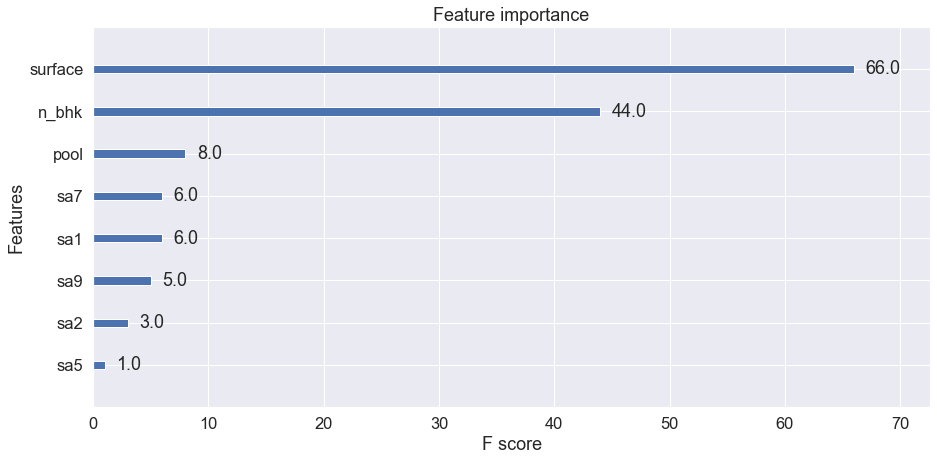

In [35]:
# plot the feature importance 
plt.rcParams["figure.figsize"] = (15,7)
xgb.plot_importance(xgbr)
plt.show()

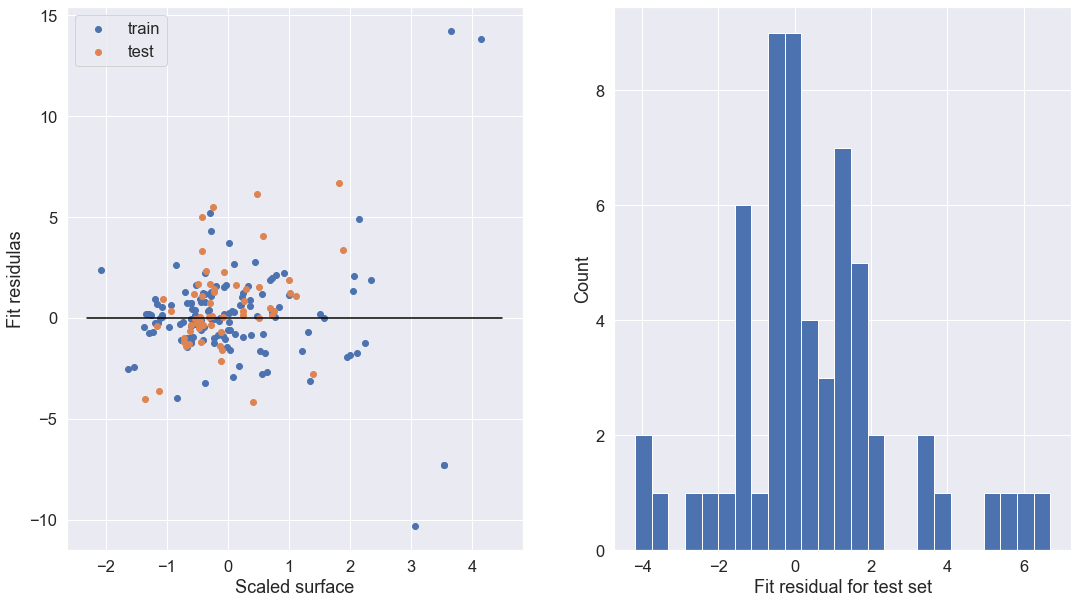

mean residuals: 0.5 
std: 2.16


In [36]:
#  plot the residuals
plotResidue(xgbr, X, y, rs=rs)

## K-Nearest Neighbours Regression

In [37]:
%%time
knn = KNeighborsRegressor() # KNN model
pg = {
    "n_neighbors": range(1,16),
    "weights": ['uniform', 'distance'],
    "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']
}
knn_cv = gridSearchReport( knn, X, y, pg, rs=rs )

Best parameters: {'algorithm': 'brute', 'n_neighbors': 3, 'weights': 'uniform'}
Best CV score: 9.081334757502027
MSE, R2 train: 5.404917731549066 ,  0.8661862400471112
MSE, R2 test: 4.786724836158192 ,  0.7204490530284717
Elapsed time: 151.7 s , 2.53 min
Wall time: 2min 31s


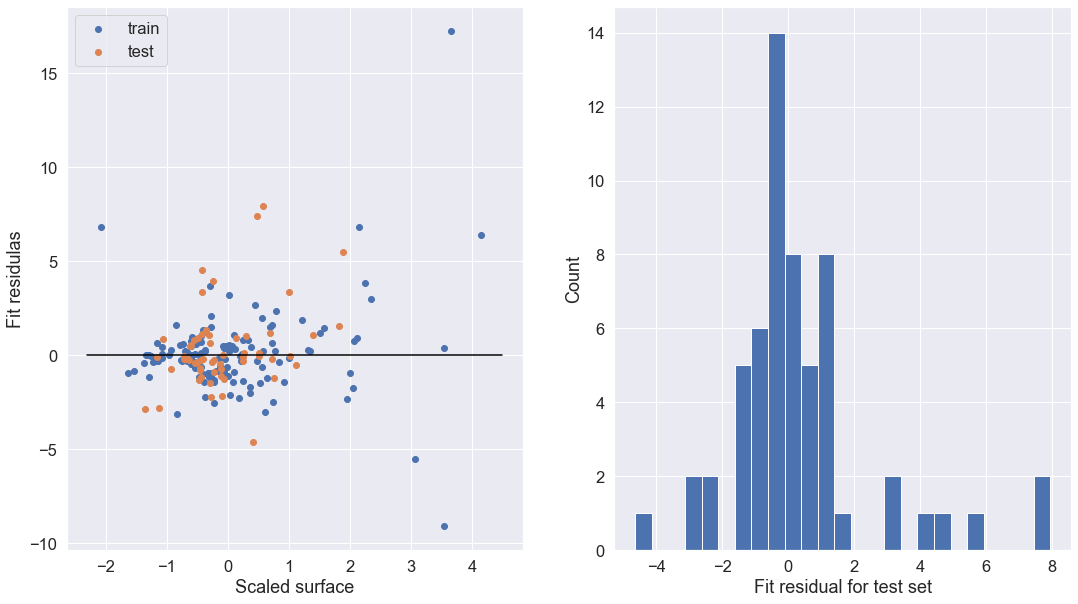

mean residuals: 0.33 
std: 2.16


In [38]:
# plot the residuals
plotResidue(knn_cv, X, y, rs=rs)

In [39]:
from sklearn.model_selection import validation_curve
param_range = range(1,31)
knn_cv = KNeighborsRegressor()
train_scores, val_scores = validation_curve(knn_cv, 
                                             X_train, y_train, 
                                             param_name="n_neighbors",
                                             param_range=param_range,
                                             n_jobs=-1,
                                             scoring="neg_mean_squared_error", 
                                             cv=10
                                            )

In [40]:
train_scores.shape

(30, 10)

In [41]:
train_mean_score = -np.mean(train_scores, axis=1)
val_mean_score = -np.mean(val_scores, axis=1)

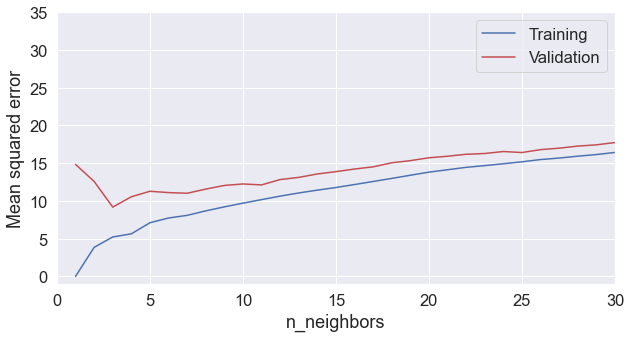

In [42]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot( param_range, train_mean_score, color="b", label="Training" )
plt.plot( param_range, val_mean_score, color="r", label="Validation" )
plt.xlim(1,15)
plt.xlabel( "n_neighbors" )
plt.ylim(-1, 35)
plt.xlim(0, 30)
plt.ylabel( "Mean squared error" )
plt.legend()
plt.show()

No handles with labels found to put in legend.


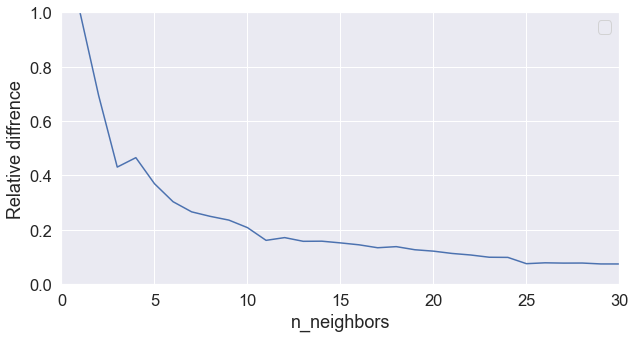

In [43]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot( param_range, (val_mean_score-train_mean_score)/val_mean_score )
plt.xlim(1,15)
plt.xlabel( "n_neighbors" )
plt.ylim(0, 1)
plt.xlim(0, 30)
plt.ylabel( "Relative diffrence" )
plt.legend()
plt.show()

In [44]:
knn_cv = KNeighborsRegressor(n_neighbors=20, weights="uniform")
knn_cv.fit( X_train, y_train )
y_pred_knn = knn_cv.predict(X_test)
print(r2_score(y_train, knn_cv.predict(X_train)) , r2_score(y_test, y_pred_knn))
mean_squared_error(y_train, knn_cv.predict(X_train)) , mean_squared_error(y_test, y_pred_knn) 

0.6746926817967747 0.6578035421266653


(13.13960009029197, 5.859398086440678)

In [45]:
from sklearn.model_selection import cross_val_score
cross_val_list = cross_val_score(knn_cv, X_train, y_train, 
                                 scoring="neg_mean_squared_error", cv=10)
score_val_knn = -np.mean(cross_val_list)
score_val_knn

15.72332720060852

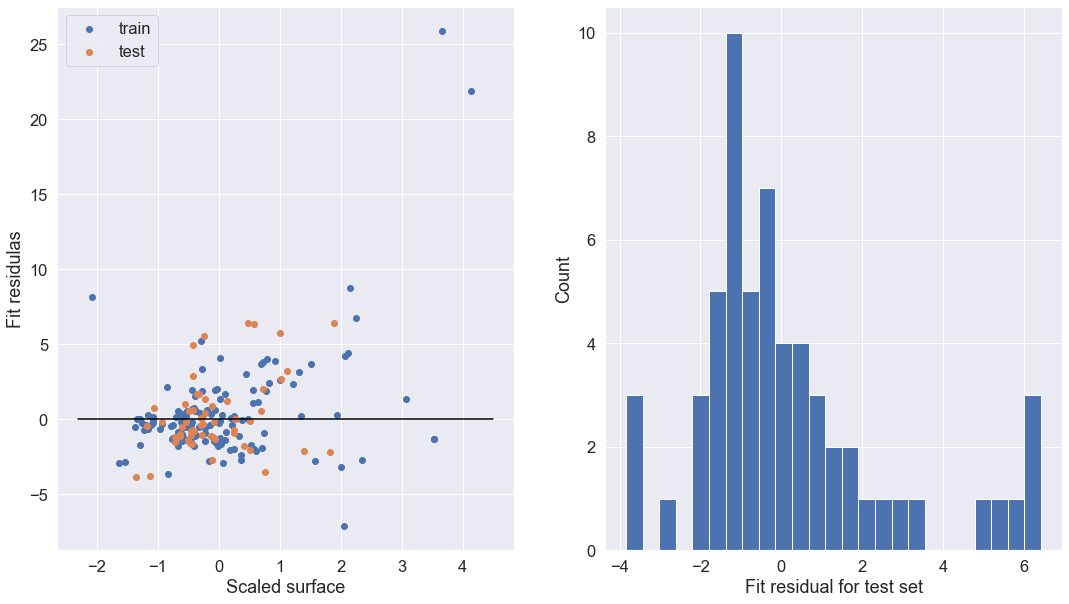

mean residuals: 0.18 
std: 2.41


In [46]:
# plot the residuals
plotResidue(knn_cv, X, y, rs=rs)

## Suport Vector Regression

In [47]:
# SVR model
svr = SVR()
pg = {
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "gamma": ['scale', 'auto'], # Kernel coefficient 
    "C": np.logspace(-3, 3, 10), # Penalty parameter
    "epsilon": np.linspace(.1, 1., 10) # the decision boundary
}
svr_cv = gridSearchReport( svr, X, y, pg, cv=10, rs=rs )


Best parameters: {'C': 1000.0, 'epsilon': 0.9, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV score: 9.229629818488117
MSE, R2 train: 1.8457032040549695 ,  0.9543044875502843
MSE, R2 test: 5.872022120340656 ,  0.6570662821520201
Elapsed time: 126.81 s , 2.11 min


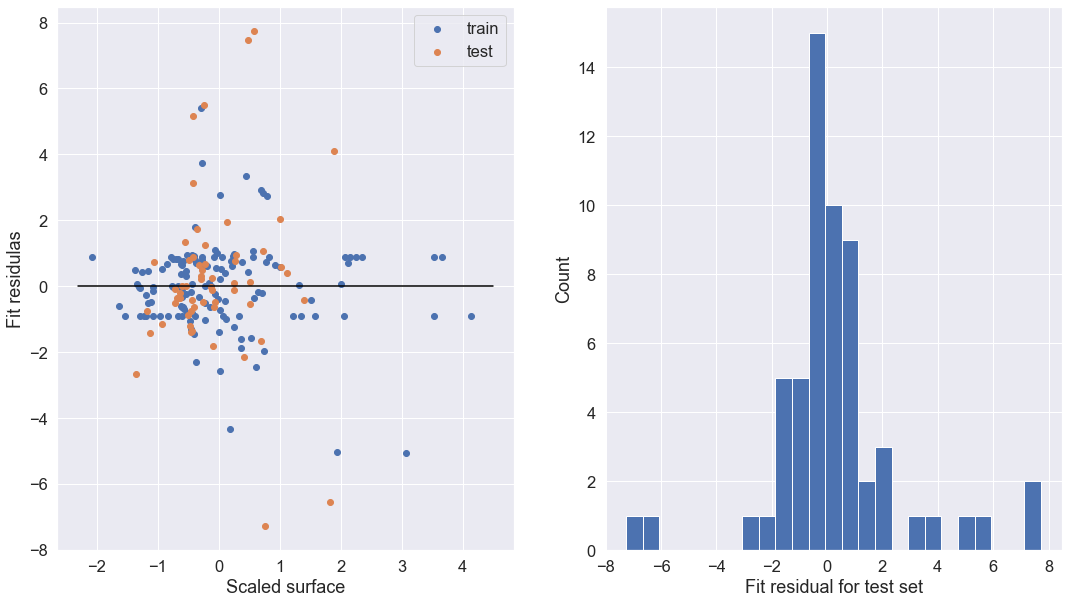

mean residuals: 0.23 
std: 2.41


In [48]:
# plot the residuals
plotResidue(svr_cv, X, y, rs=rs)

## Comparing the estimators

In [49]:
# fcuntions to make a comparision between all the models
def sortXy( X, y ):
    """
    Prepares the features to have the fit only for "surface" variable. 
    """ 
    df = X.copy()
    df["price"] = y
    df = df.sort_values("surface").reset_index(drop=True)
    return df.drop(columns=["price"]), df["price"]

#######################################
def get_scores( X, y, est_name, est ):
    """
    Computes the validation and tets scores. 
    Params:
        X: Pandas dataframe, feature data
        y: Pandas series, target
        est_name: str
            estromator name
        est: regressor
            the regression estimator
    Return:
        r2 for the test sample, mse for validation sample and the labels for plotting.
    """    
    y_pred = est.predict(X)
    r2_test = round(r2_score(y, y_pred), 1)
    if est_name=="Linear Regression" :
        mse_cv = "--"
    elif est_name=="Extreme Gradient Boosting":
        mse_cv = round(df_grid_best["val_score"].to_list()[0],1)
    elif est_name=="K-Nearest Neighbors Regression":
        mse_cv = round(score_val_knn,1)
    else :
        mse_cv=round(abs(est.best_score_), 1)
    
    lbl = est_name+":  R2_test="+str(r2_test)+", MSE_cv="+str(mse_cv)
    
    return r2_test, mse_cv, lbl

    
#######################################
def plotLines( X, y, estimators, rs):
    """
    Plots the fitted curve for the given estimators to test data vs. "surface" variable.
    Params:
        X: Pandas dataframe 
            features 
        y: Pandas series 
            target
        estimators: list 
            list of regressors
        rs: int 
            random state
    """    
    X, y = sortXy( X, y )
    colors = ["k", "b", "r", "g"]
    fig, axe = plt.subplots(figsize=(20,10))
    axe.scatter( X["surface"], y )
    i = 0
    for k, estimator  in estimators.items():
        r2_test, mse_cv, label = get_scores( X, y, k, estimator )
        axe.plot(X["surface"], estimator.predict(X), label=label, c=colors[i])
        i+=1
    axe.set_xlabel("Scaled surface")
    axe.set_ylabel("Price in millions")
    axe.legend()



In [50]:
estimators1 = {
              "Linear Regression": lr, 
              "Ridge Regression": ridg_cv, 
              "Lasso Regression": lasso_cv, 
              "Elastic Net": elastic_cv, 
}

estimators2 = {              
              "Random Forest Regression": rfr_cv, 
              "Extreme Gradient Boosting": xgbr, 
              "K-Nearest Neighbors Regression": knn_cv, 
              "Support Vector Regression": svr_cv
}



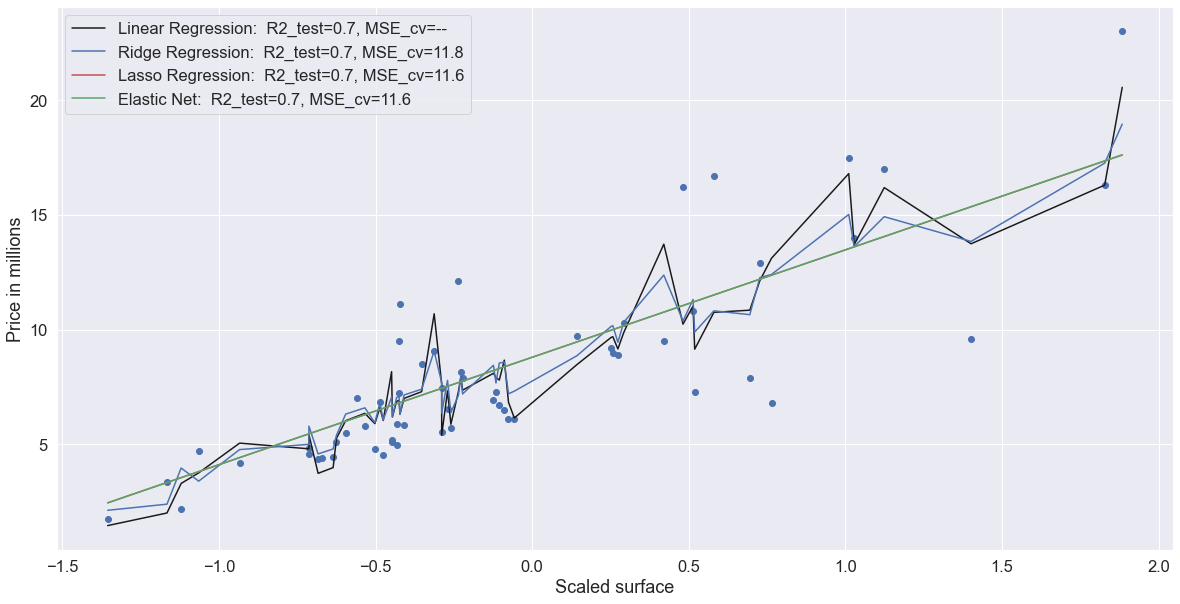

In [51]:
plotLines(X_test ,y_test, estimators1, rs=rs)

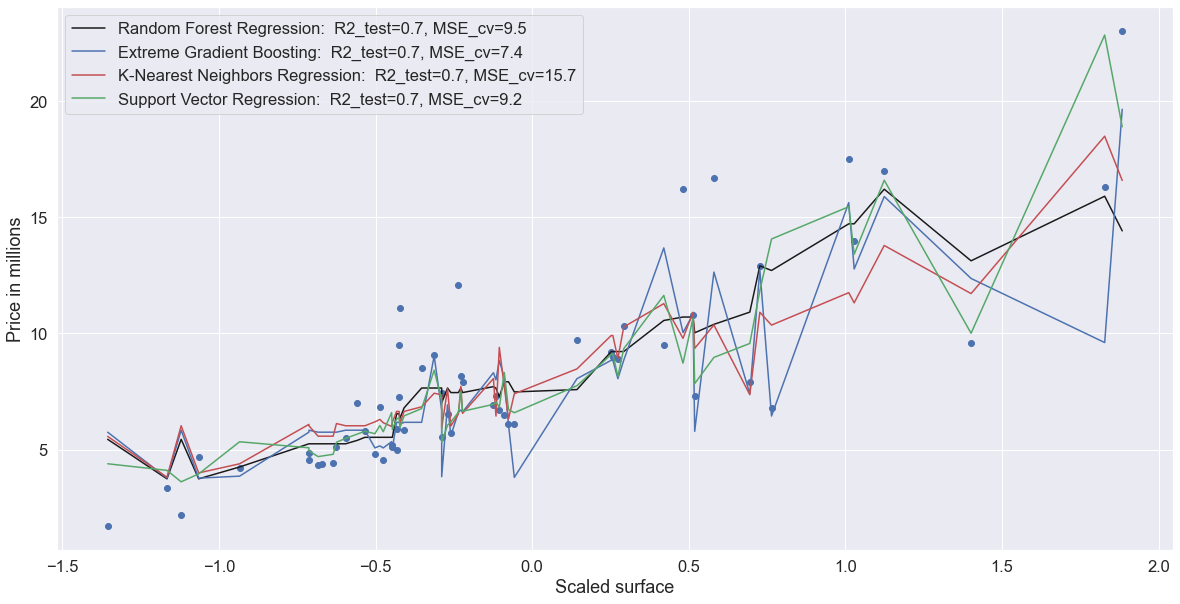

In [52]:
plotLines(X_test,y_test, estimators2, rs=rs)

# Conclusion

We have conclude that our best estimator at first is the  - 

Extreme Gradient boosting 

followd by Support Vector Regressor and then the Linear regression methods